# Data Science Capstone Project - Notebook
The present Jupyter Notebook implements assignments of the course "Applied Data Science Capstone", the last of the nine courses of the IBM Professional Certification "Data Science".

-----

# __Car Accident Severity Prediction Based on Contextual Conditions__

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## __Introduction__ <a id="introduction"></a>

### Business Understanding

The goal of the project is to build a predictor capable of predicting the severity of a road accident given traffic, weather and other environmental conditions. The severity is to be predicted in terms of a property damage only or with some type of bodily injury event in case of accident. The purpose of the predictor is to help travellers to judge if the conditions they are currently encountering during their trip are a known factor relevant for serious consequences in case of accident or not. The idea for reaching the goal is to use the accident dataset maintained and made publicly available by the Transportation Department of the City of Seattle. This accident dataset can be retrieved in CSV format at the address https://data-seattlecitygis.opendata.arcgis.com/datasets/collisions. Such dataset will be use to build and validate a predictor using the Machine Learning techniques presented in the courses of the "IBM Data Science Professional Certificate" series on Coursera.

## __Data__ <a id="data"></a>

### Data Understanding

Following a first analysis of the accident dataset provided by the City of Seattle Transportation Department, the following columns are found to be representative of the conditions that are felt to be most relevant to affect the severity of an accident:
* LOCATION - Location of the accident
* JUNCTIONTYPE - Type of of road junction (mid-block with or without junction, intersection, driveway, ramp, etc.)
* WEATHER - Weather condition (Overcast, Raining, Clear, Snowing, etc.)
* ROADCOND - Road condition (Wet, Dry, Snow/Slush, Ice, etc.)
* LIGHTCOND - Lighting conditions (Daylight, Dark - Street Lights On, Dark - No Street Lights, etc.)
* SPEEDING - Speeding vehicles (Yes or No)
* VEHCOUNT - Number of vehicles involved
* PERSONCOUNT - Number of persons involved

The target field that the predictor will need to predict is "SEVERITYCODE", with the values 2 and 1 for 'Injury Collision' and 'Property Damage Only Collision'.

Based on the above column selection, a first analysis of the raw data provides the following results:

In [174]:
# import the needed libraries
import pandas as pd
import numpy as np

# load the SDOT dataset
rawdata = pd.read_csv('Data-Collisions.csv', low_memory=False)

# Check the cardinality of the dataset
print('Dataset shape:', rawdata.shape)

Dataset shape: (194673, 38)


In [175]:
# Study the content of the columns selected for the analysis
print('SEVERITYCODE unique values:', rawdata['SEVERITYCODE'].unique())
print('SEVERITYDESC unique values:', rawdata['SEVERITYDESC'].unique())
print('JUNCTIONTYPE unique values:', rawdata['JUNCTIONTYPE'].unique())
print('WEATHER unique values:', rawdata['WEATHER'].unique())
print('ROADCOND unique values:', rawdata['ROADCOND'].unique())
print('LIGHTCOND unique values:', rawdata['LIGHTCOND'].unique())
print('SPEEDING unique values:', rawdata['SPEEDING'].unique())
print()
print('Number of damage-only incidents:', len(rawdata[rawdata.SEVERITYCODE == 1]))
print('Number of bodily injury incidents:', len(rawdata[rawdata.SEVERITYCODE == 2]))
print()
print('Number of unique LOCATION:', len(rawdata['LOCATION'].unique()))
print()
damage_loc = rawdata[rawdata['SEVERITYCODE'] == 1].groupby(['LOCATION']).size().sort_values(ascending=False)
print('Most typical locations for damage-only incidents:', damage_loc[damage_loc > 100])
print()
injury_loc = rawdata[rawdata['SEVERITYCODE'] == 2].groupby(['LOCATION']).size().sort_values(ascending=False)
print('Most typical locations for bodily injury incidents:', injury_loc[injury_loc > 100])
print()
print('Number of incidents by JUNCTIONTYPE value:', rawdata.groupby(['JUNCTIONTYPE']).size().sort_values(ascending=False))
print()
print('Number of incidents by WEATHER value:', rawdata.groupby(['WEATHER']).size().sort_values(ascending=False))
print()
print('Number of incidents by ROADCOND value:', rawdata.groupby(['ROADCOND']).size().sort_values(ascending=False))
print()
print('Number of incidents by LIGHTCOND value:', rawdata.groupby(['LIGHTCOND']).size().sort_values(ascending=False))
print()
print('Number of incidents by SPEEDING value:', rawdata.groupby(['SPEEDING']).size().sort_values(ascending=False))

SEVERITYCODE unique values: [2 1]
SEVERITYDESC unique values: ['Injury Collision' 'Property Damage Only Collision']
JUNCTIONTYPE unique values: ['At Intersection (intersection related)'
 'Mid-Block (not related to intersection)' 'Driveway Junction'
 'Mid-Block (but intersection related)'
 'At Intersection (but not related to intersection)' nan 'Unknown'
 'Ramp Junction']
WEATHER unique values: ['Overcast' 'Raining' 'Clear' nan 'Unknown' 'Other' 'Snowing'
 'Fog/Smog/Smoke' 'Sleet/Hail/Freezing Rain' 'Blowing Sand/Dirt'
 'Severe Crosswind' 'Partly Cloudy']
ROADCOND unique values: ['Wet' 'Dry' nan 'Unknown' 'Snow/Slush' 'Ice' 'Other' 'Sand/Mud/Dirt'
 'Standing Water' 'Oil']
LIGHTCOND unique values: ['Daylight' 'Dark - Street Lights On' 'Dark - No Street Lights' nan
 'Unknown' 'Dusk' 'Dawn' 'Dark - Street Lights Off' 'Other'
 'Dark - Unknown Lighting']
SPEEDING unique values: [nan 'Y']

Number of damage-only incidents: 136485
Number of bodily injury incidents: 58188

Number of unique LOCAT

### Data Preparation and Cleaning

The above results call for a clean-up of the dataset consisting of a number of adjustments as follows:

In [176]:
data = rawdata[['SEVERITYCODE', 'LOCATION', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'VEHCOUNT', 'PERSONCOUNT']].copy(deep=True)

* Transformation of SPEEDING column "NaN" values into "0" for "No" and of "Y" values into "1" for "Yes"

In [177]:
data['SPEEDING'].replace(np.nan, 0, inplace = True)
data['SPEEDING'].replace('Y', 1, inplace = True)

* Elimination of all records containing "NaN" values or other undefined column values like "Unknown" 

In [178]:
data = data.dropna(axis=0, how='any')
data.drop(data[data['JUNCTIONTYPE'] == 'Unknown'].index, inplace = True)
data.drop(data[data['WEATHER'] == 'Unknown'].index, inplace = True)
data.drop(data[data['WEATHER'] == 'Other'].index, inplace = True)
data.drop(data[data['ROADCOND'] == 'Unknown'].index, inplace = True)
data.drop(data[data['ROADCOND'] == 'Other'].index, inplace = True)
data.drop(data[data['LIGHTCOND'] == 'Other'].index, inplace = True)

* Substitution of the LOCATION identifier column with the probability of a bodily injury in case of an incident at that location based on the content of the dataset, as it is felt that such indication can help the predictor in identifying the severity of the incident at a certain location much more than a categorization of the very numerous locations (over 2000) mentioned in the dataset.

In [180]:
loc_data = pd.DataFrame(data=data['LOCATION'].unique(), index=None, columns=['LOCATION']).sort_values('LOCATION')
loc_data.index = loc_data['LOCATION']
loc_data.drop(['LOCATION'], axis=1, inplace=True)
loc_damages = pd.DataFrame(data[data['SEVERITYCODE'] == 1].groupby(['LOCATION']).size(), columns=['DAMAGES'])
loc_injuries = pd.DataFrame(data[data['SEVERITYCODE'] == 2].groupby(['LOCATION']).size(), columns=['INJURIES'])
loc_data['LOCINJRISK'] = loc_injuries['INJURIES'] / (loc_damages['DAMAGES'] + loc_injuries['INJURIES'])
loc_data['LOCINJRISK'].replace(np.nan, 0, inplace = True)
data = pd.merge(data, loc_data, on='LOCATION', how='inner')

The dataset resulting from the above adjustments is as follows:

In [181]:
data

,SEVERITYCODE,LOCATION,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,VEHCOUNT,PERSONCOUNT,LOCINJRISK
0,2,5TH AVE NE AND NE 103RD ST,At Intersection (intersection related),Overcast,Wet,Daylight,0,2,2,0.483871
1,1,5TH AVE NE AND NE 103RD ST,At Intersection (intersection related),Overcast,Dry,Dark - Street Lights On,0,3,4,0.483871
2,2,5TH AVE NE AND NE 103RD ST,At Intersection (intersection related),Clear,Dry,Daylight,0,3,5,0.483871
3,2,5TH AVE NE AND NE 103RD ST,At Intersection (intersection related),Overcast,Wet,Daylight,0,2,2,0.483871
4,1,5TH AVE NE AND NE 103RD ST,At Intersection (intersection related),Overcast,Wet,Daylight,0,2,2,0.483871
...,...,...,...,...,...,...,...,...,...,...
169282,2,5TH AVE W BETWEEN W FULTON ST AND W BARRETT S ST,Mid-Block (not related to intersection),Clear,Dry,Dusk,0,2,2,0.000000
169283,1,SW OTHELLO ST BETWEEN 29TH AVE SW AND 30TH AVE SW,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,0,2,2,0.000000
169284,2,5TH AVE S BETWEEN S LUCILE ST AND S FINDLAY ST,Driveway Junction,Clear,Dry,Daylight,0,2,2,0.000000
169285,1,NE PARK RD AND NE RAVENNA WB BV,At Intersection (intersection related),Clear,Dry,Daylight,0,2,2,0.000000


In [182]:
data.dtypes

SEVERITYCODE      int64
LOCATION         object
JUNCTIONTYPE     object
WEATHER          object
ROADCOND         object
LIGHTCOND        object
SPEEDING          int64
VEHCOUNT          int64
PERSONCOUNT       int64
LOCINJRISK      float64
dtype: object

### Data Pre-Processing
A final adjustment before building the predictor is to transform the categorical features selected for predicting the incident severity into numerical values that can be used by the Machine Learning techniques that will be used to develop the predictor.

In [193]:
X = data[['JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'VEHCOUNT', 'PERSONCOUNT', 'LOCINJRISK']].values
#X = data[['JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'VEHCOUNT', 'PERSONCOUNT']].values
#X = data[['SPEEDING', 'VEHCOUNT', 'PERSONCOUNT', 'LOCINJRISK']].values
#X = data[['VEHCOUNT', 'PERSONCOUNT', 'LOCINJRISK']].values
#X = data[['LOCINJRISK']].values
#X = data[['JUNCTIONTYPE', 'SPEEDING', 'VEHCOUNT', 'PERSONCOUNT', 'LOCINJRISK']].values
y = data['SEVERITYCODE']

In [194]:
print('JUNCTIONTYPE unique values:', data['JUNCTIONTYPE'].unique())
print('WEATHER unique values:', data['WEATHER'].unique())
print('ROADCOND unique values:', data['ROADCOND'].unique())
print('LIGHTCOND unique values:', data['LIGHTCOND'].unique())

JUNCTIONTYPE unique values: ['At Intersection (intersection related)'
 'At Intersection (but not related to intersection)'
 'Mid-Block (not related to intersection)'
 'Mid-Block (but intersection related)' 'Driveway Junction'
 'Ramp Junction']
WEATHER unique values: ['Overcast' 'Clear' 'Raining' 'Blowing Sand/Dirt' 'Snowing'
 'Fog/Smog/Smoke' 'Sleet/Hail/Freezing Rain' 'Severe Crosswind'
 'Partly Cloudy']
ROADCOND unique values: ['Wet' 'Dry' 'Ice' 'Snow/Slush' 'Standing Water' 'Oil' 'Sand/Mud/Dirt']
LIGHTCOND unique values: ['Daylight' 'Dark - Street Lights On' 'Dusk' 'Unknown' 'Dawn'
 'Dark - Street Lights Off' 'Dark - No Street Lights'
 'Dark - Unknown Lighting']


In [195]:
from sklearn import preprocessing

le_junctiontype = preprocessing.LabelEncoder()
le_junctiontype.fit(['At Intersection (intersection related)', 'Mid-Block (not related to intersection)', 'Driveway Junction',
                     'Mid-Block (but intersection related)', 'At Intersection (but not related to intersection)', 'Ramp Junction'])
X[:, 0] = le_junctiontype.transform(X[:, 0]) 

le_weather = preprocessing.LabelEncoder()
le_weather.fit(['Overcast', 'Clear', 'Raining', 'Blowing Sand/Dirt', 'Snowing', 'Fog/Smog/Smoke', 
                'Sleet/Hail/Freezing Rain', 'Severe Crosswind', 'Partly Cloudy'])
X[:, 1] = le_weather.transform(X[:, 1])

le_roadcond = preprocessing.LabelEncoder()
le_roadcond.fit(['Wet', 'Dry', 'Ice', 'Snow/Slush', 'Standing Water', 'Oil', 'Sand/Mud/Dirt'])
X[:, 2] = le_roadcond.transform(X[:, 2]) 

le_lightcond = preprocessing.LabelEncoder()
le_lightcond.fit(['Daylight', 'Dark - Street Lights On', 'Dusk', 'Unknown', 'Dawn', 'Dark - Street Lights Off', 
             'Dark - No Street Lights', 'Dark - Unknown Lighting'])
X[:, 3] = le_lightcond.transform(X[:, 3]) 

Following the above categorization the data set results to be as follows:

In [196]:
print('X, the Feature Matrix (data):', X)
print()
print('y, the response vector (target):', y)

X, the Feature Matrix (data): [[1 3 6 ... 2 2 0.4838709677419355]
 [1 3 0 ... 3 4 0.4838709677419355]
 [1 1 0 ... 3 5 0.4838709677419355]
 ...
 [2 1 0 ... 2 2 0.0]
 [1 1 0 ... 2 2 0.0]
 [4 5 6 ... 1 1 0.0]]

y, the response vector (target): 0         2
1         1
2         2
3         2
4         1
         ..
169282    2
169283    1
169284    2
169285    1
169286    1
Name: SEVERITYCODE, Length: 169287, dtype: int64


In [197]:
# apparently not needed
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

The final step of the pre-processing is the separation of the data set into a train set for the development of the predictor and a test set for its validation.

In [198]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (135429, 8) (135429,)
Test set: (33858, 8) (33858,)


In [199]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## __Methodology__ <a id="methodology"></a>
In the present section various predictors are built usign the train data set according to the Machine Learning techniques presented during the specialization courses series. The predictors are then validated using the test set previously prepared and a table is finally presented to summarize the performance of the various predictors and indicate the one that provides the best accuracy.

Before building and evaluating the various predictors, it is useful to evaluate the level of correlation in the available dataset to assess the chances that we will have to build solid predictors for identifuing the incident severity in terms of damage-only or bodily injury in case of incident given the incident features identified. Such an assessment is possible by building a "heatmap" to represent the mutual correlation between the features and the target. Analyzing the prepared data the heatmap is as follows:

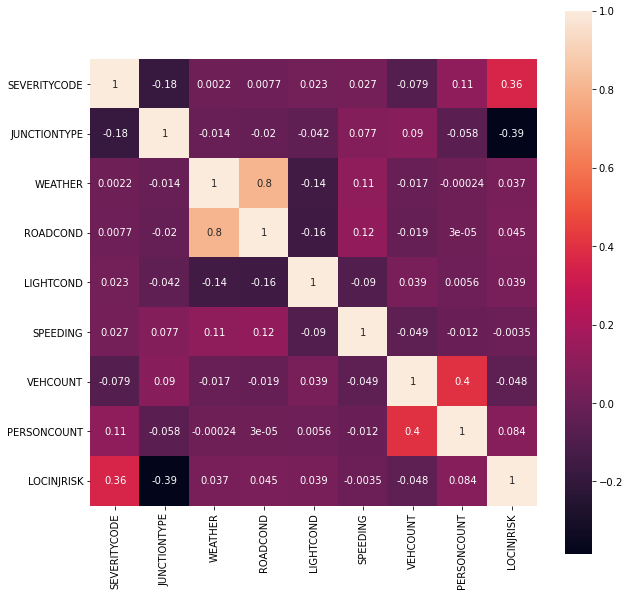

In [207]:
adjdata = data.copy(deep=True)
adjdata.iloc[:, 2] = le_junctiontype.transform(adjdata.iloc[:, 2])
adjdata.iloc[:, 3] = le_weather.transform(adjdata.iloc[:, 3])
adjdata.iloc[:, 4] = le_roadcond.transform(adjdata.iloc[:, 4]) 
adjdata.iloc[:, 5] = le_lightcond.transform(adjdata.iloc[:, 5])
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(adjdata.corr(), annot = True, square=True, ax=ax)
plt.show()

It can be seen that in general the level of mutual correlation between the various features and the target is very poor. Most of the correlations are very close to zero with only few unsurprising exceptions:

* The strongest correlation (value 0.8) appears to be between the weather (WEATHER) and the road condition (ROADCOND) features. This is typically related to the fact that a rainy weather is connected to a wet road, clear weather is connected to a dry road, etc.
* A second significant correlation (value 0.8) is present between the number of vehicles (VEHCOUNT) and the number of people (PERSONCOUNT) involved in the incident. Also this correlation is unsurprising as it is to be expected that with more vehicles are involved also the number of people will inevitably grow and viceversa.
* The third significant correlation (value 0.36) is between the target feature severity code (SEVERITYCODE) and the newly added feature representing the likeliness of a bodily injury vs. a damage-only at the incident location (LOCINJRISK), which was calculated according to the severity of the incidents recorded in the dataset for the various locations.

Being connected to the target feature, the third correlation appears to be the most useful one for helping the prediction of the incident severity. Due to the absence of further helpful correlations it is to be expected that it will be difficult to build predictors with a good level of accuracy. Nevertheless let us build and compare the performance of possible predictors built using the following Machine Learning techniques:

* Logistic Regression
* Support Vector Machine (SVM)
* K-Nearest Neighbor (KNN)
* Decision Tree

Using each single of the above techniques and the Python library "Scikit Learn", a predictor will be built using the previosuly prepared train data set and the accuracy will be assessed using the previously prepared test data set. The resulting prediction accuracies will be then gathered in a single table, which will be commented in the "Results" section of the present report. 

In [29]:
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Modeling with Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [31]:
yhat = LR.predict(X_test)

In [32]:
yhat_prob = LR.predict_proba(X_test)

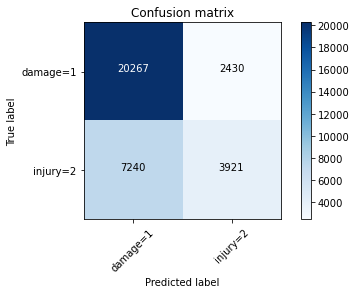

In [33]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['damage=1','injury=2'], normalize= False,  title='Confusion matrix')

In [34]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           1       0.74      0.89      0.81     22697
           2       0.62      0.35      0.45     11161

    accuracy                           0.71     33858
   macro avg       0.68      0.62      0.63     33858
weighted avg       0.70      0.71      0.69     33858



In [35]:
print('Jaccard score:', jaccard_score(y_test, yhat))
print('F1-score:', f1_score(y_test, yhat))
print('Log-loss score:', log_loss(y_test, yhat_prob))

Jaccard score: 0.6769883421852557
F1-score: 0.8073858656680741
Log-loss score: 0.5546087301960763


### Modeling with SVM

In [36]:
from sklearn import svm
SVM = svm.SVC(kernel='linear', gamma='scale', probability=True).fit(X, y)
SVM

SVC(kernel='linear', probability=True)

In [40]:
yhat = SVM.predict(X_test)

In [38]:
yhat_prob = SVM.predict_proba(X_test)

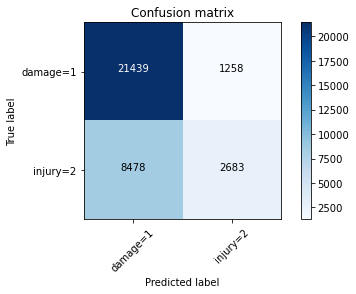

In [41]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['damage=1','injury=2'], normalize= False,  title='Confusion matrix')

In [42]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           1       0.72      0.94      0.81     22697
           2       0.68      0.24      0.36     11161

    accuracy                           0.71     33858
   macro avg       0.70      0.59      0.59     33858
weighted avg       0.70      0.71      0.66     33858



In [43]:
print('Jaccard score:', jaccard_score(y_test, yhat))
print('F1-score:', f1_score(y_test, yhat))
print('Log-loss score:', log_loss(y_test, yhat_prob))

Jaccard score: 0.6876984763432238
F1-score: 0.8149541947010301
Log-loss score: 0.5613624392049108


### Modeling with KNN

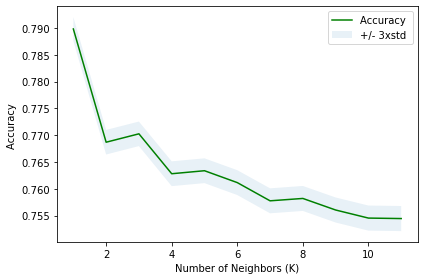

Best Accuracy is 0.7897985705003249 for k = 1


KNeighborsClassifier(n_neighbors=1)

In [214]:
from sklearn.neighbors import KNeighborsClassifier

# explore the performance of KNN on the train-test set for various possible levels of "k"
Ks = 12
mean_acc = np.zeros((Ks - 1))
std_acc = np.zeros((Ks - 1))
best_acc = 0
best_k = 0

for k in range(1, Ks):
    KNN = KNeighborsClassifier(n_neighbors = k).fit(X, y)
    yhat = KNN.predict(X_test)
    mean_acc[k - 1] = metrics.accuracy_score(y_test, yhat)
    std_acc[k - 1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])
    if mean_acc[k - 1] > best_acc:
        best_acc = mean_acc[k - 1]
        best_k = k

plt.plot(range(1, Ks), mean_acc, 'g')
plt.fill_between(range(1, Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print('Best Accuracy is', best_acc, 'for k =', best_k)
KNN = KNeighborsClassifier(n_neighbors = best_k).fit(X, y)
KNN

In [215]:
yhat = KNN.predict(X_test)

In [216]:
yhat_prob = KNN.predict_proba(X_test)

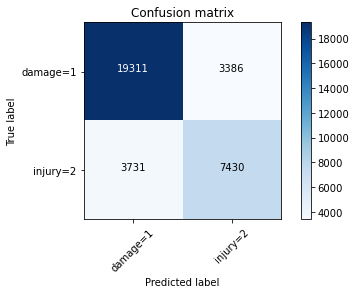

In [217]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['damage=1','injury=2'], normalize= False,  title='Confusion matrix')

In [218]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           1       0.84      0.85      0.84     22697
           2       0.69      0.67      0.68     11161

    accuracy                           0.79     33858
   macro avg       0.76      0.76      0.76     33858
weighted avg       0.79      0.79      0.79     33858



In [219]:
print('Jaccard score:', jaccard_score(y_test, yhat))
print('F1-score:', f1_score(y_test, yhat))
print('Log-loss score:', log_loss(y_test, yhat_prob))

Jaccard score: 0.7307022854548206
F1-score: 0.8443997463871095
Log-loss score: 7.260100171379862


### Modeling with Decision Tree

In [208]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(criterion="entropy", max_depth=30).fit(X, y)
DT

DecisionTreeClassifier(criterion='entropy', max_depth=30)

In [209]:
yhat = DT.predict(X_test)

In [210]:
yhat_prob = DT.predict_proba(X_test)

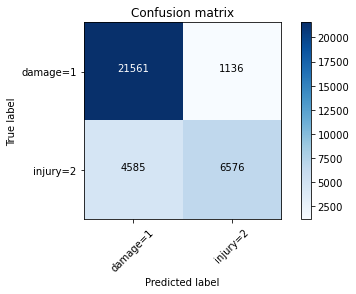

In [211]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['damage=1','injury=2'], normalize= False,  title='Confusion matrix')

In [212]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           1       0.82      0.95      0.88     22697
           2       0.85      0.59      0.70     11161

    accuracy                           0.83     33858
   macro avg       0.84      0.77      0.79     33858
weighted avg       0.83      0.83      0.82     33858



In [205]:
print('Jaccard score:', jaccard_score(y_test, yhat))
print('F1-score:', f1_score(y_test, yhat))
print('Log-loss score:', log_loss(y_test, yhat_prob))

Jaccard score: 0.7057160587464663
F1-score: 0.8274719055703776
Log-loss score: 0.5018186555575692


In [ ]:
# let's have a look at the created decision tree
#from sklearn.externals.six import StringIO
from six import StringIO
import pydotplus
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 
dot_data = StringIO()
filename = "DT.png"
featureNames = ['JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'VEHCOUNT', 'PERSONCOUNT', 'LOCINJRISK']
targetNames = data['SEVERITYCODE'].unique().tolist()
out = tree.export_graphviz(DT, feature_names=featureNames, out_file=dot_data, class_names=['DAMAGE', 'INJURY'], filled=True, special_characters=True, rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img, interpolation='nearest')
plt.show()

## __Results__ <a id="results"></a>

The following table summarizes the weighed accuracies on precision and recall plus F1 scores achieved by the various predictors on the test data set:


| Predictor Type            | Weighed Avg. Precision | Weighed Avg. Recall | Weighed Avg. F1 Score | Notes | 
|:--------------------------|:------------:|:------------:|:------------:|:----------------|
| Logistic Regression       | 0.70         | 0.71         | 0.69         |                 |
| Support Vector Regression | 0.70         | 0.71         | 0.66         |                 |
| K-Nearest Neighbor        | 0.79         | 0.79         | 0.79         |                 |
| Decision Tree             | 0.83         | 0.83         | 0.82         | Best performer! |



## __Discussion__ <a id="discussion"></a>

### Evaluation

It must be noted that the performances achieved by the various predictors were in general surprisingly good despite the heatmap of the correlations between the features showed quite poor and unpromising values. The Decision Tree predictor clearly proved to be the most accurate in this case. This result was obtained building a quite deep tree, whch in any case resulted in a quite short training time, actually much shorter than the ones that were required for training the SVM and KNN predictors.

## __Conclusion__ <a id="conclusion"></a>

The project consisted in building a successful predictor to predict the severity in terms of "damage-only" or "bodiliy injury" of the outcome of a car incident occurring in the Seattle city area given a number of environmental conditions consisting of location, road condition, weather condition, road junction type, speeding, number of people involved, light conditions, number of vehicles involved.

The data available for building the predictor consisted in a CSV file maintained by the Departmentt of Traffic of Seattle consisting of 169287 records. Such data set was divided into two distinct sets of 135429 records for training candidate predictors and 33858 records for testing them.

In order to find a good solution, multiple predictors have been built using the different Machine Learning techniques suitable for binary predictions presented during the specialization courses. In particular four predictors have been built based on Logistic Regression, Support Vector Machine (SVM), K-Nearest Neighbor (KNN) and Decision Tree.

The comparison of the performances of the four predictors on the test set indicated that the Decision Tree predictor was the best performer in terms of accuracy.